# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Understand batching for a recurrent neural network, and develop custom Dataset and DataLoaders with collate_fn to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [2]:
for line in open('SMSSpamCollection'):
    label, text = line.strip().split('\t')
    print("label: ", label)
    print("text: ", text)
    break

label:  ham
text:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [3]:
import pandas as pd

data = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'text'])

# display the length of spam and ham messages
data['label'].value_counts()


label
ham     4825
spam     747
Name: count, dtype: int64

### Part (c) [4 pt]

load and parse the data into two lists: sequences and labels. Create character-level stoi and itos dictionaries. Reserve the index 0 for padding. Convert the sequences to list of character ids using stoi dictionary and convert the labels to a list of 0s and 1s by assinging class "ham" to 0 and class "spam" to 1.

In [ ]:
characters = set()
label2idx = {'ham': 0, 'spam': 1}
characters_counter = 1

def turn_sentence_into_stoi(sentence):
    global characters_counter
    stoi_list = []
    # turn sentence to lower case
    sentence = sentence.lower()
    # split the sentence into characters
    for character in sentence:
        if character not in characters:
            characters.add(character)
            stoi_list.append(characters_counter)
            characters_counter += 1
        else:
            # find the index of the character in the set
            stoi_list.append(list(characters).index(character) + 1)

    return stoi_list


data['text_transformed'] = data['text'].apply(turn_sentence_into_stoi)

data['label_transformed'] = data['label'].apply(lambda x: label2idx[x])

data

,label,text,text_transformed,label_transformed
0,ham,"Go until jurong point, crazy.. Available only ...","[1, 2, 3, 4, 5, 6, 7, 8, 1, 9, 2, 10, 3, 7, 4,...",0
1,ham,Ok lar... Joking wif u oni...,"[9, 27, 7, 22, 3, 4, 25, 25, 25, 7, 26, 10, 1,...",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[24, 4, 15, 15, 7, 15, 5, 6, 4, 20, 7, 12, 5, ...",1
3,ham,U dun say so early hor... U c already then say...,"[30, 11, 35, 30, 5, 11, 2, 3, 31, 11, 2, 15, 1...",0
4,ham,"Nah I don't think he goes to usf, he lives aro...","[5, 3, 23, 11, 21, 11, 35, 15, 5, 10, 7, 11, 7...",0
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,"[47, 81, 8, 43, 76, 8, 43, 76, 47, 81, 59, 76,...",1
5568,ham,Will ü b going to esplanade fr home?,"[90, 8, 85, 85, 76, 73, 76, 38, 76, 15, 77, 8,...",0
5569,ham,"Pity, * was in mood for that. So...any other s...","[53, 8, 47, 14, 5, 76, 6, 76, 90, 1, 43, 76, 8...",0
5570,ham,The guy did some bitching but I acted like i'd...,"[47, 81, 59, 76, 15, 13, 14, 76, 62, 8, 62, 76...",0


### Part (d) [4 pt]

Use train_test_split function from sklearn (https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) to split the data indices into `train`, `valid`, and `test`. Use a 60-20-20 split. 

You saw in part (b) that there are many more non-spam messages than spam messages. This **imbalance** in our training data will be problematic for training. We can fix this disparity by duplicating spam messages in the training set, so that the training set is roughly balanced.

In [5]:
# split the data into train, validation and test
from sklearn.model_selection import train_test_split

index = np.arange(len(data))
train_indedx, test_index = train_test_split(index, test_size=0.1, random_state=42)
train_indedx, val_index = train_test_split(train_indedx, test_size=0.1, random_state=42)

x = data['text_transformed'].values
y = data['label_transformed'].values

train_x = [x[idx] for idx in train_indedx]
train_y = [y[idx] for idx in train_indedx]
val_x = [x[idx] for idx in val_index]
val_y = [y[idx] for idx in val_index]
test_x = [x[idx] for idx in test_index]
test_y = [y[idx] for idx in test_index]

# Balance the train classes
train_spam = []
for idx, item in enumerate(train_x):
    if train_y[idx] == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train_x = train_x + train_spam * 6
train_y = train_y + [1] * (len(train_spam) * 6)

# varify the balance
print("train_y: ", train_y.count(1))
print("train_y: ", train_y.count(0))


train_y:  4291
train_y:  3899


### Part (e) [4 pt]

Since each sequence has a different length, we cannot use the default DataLoader. We need to change the DataLoader such that it can pad differnt sequence sizes within the batch. To do this, we need to introduce a **collate_fn** to the DataLoader such that it uses **pad_sequence** function (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) to pad the sequences within the batch to the same size. 

We also need a custom Dataset class to return a pair of sequence and label for each example. Complete the code below to address these.

Hint: 
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

In [6]:
# import the collate_fn
from torch.nn.utils.rnn import pad_sequence


class MyDataset(Dataset):
    """
    Since each sequence has a different length, we cannot use the default DataLoader. 
    We need to change the DataLoader such that it can pad differnt sequence sizes within the batch. 
    To do this, we need to introduce a **collate_fn** to the DataLoader such that it uses **pad_sequence** function 
    to pad the sequences within the batch to the same size. 
    We also need a custom Dataset class to return a pair of sequence and label for each example. Complete the code below to address these.
    """
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx])

def collate_sequences(batch):
    sequences = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    # padding sures all the sequences in the batch have the same length
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return sequences_padded, labels
    
train_loader = DataLoader(dataset=MyDataset(train_x, train_y), batch_size=32, shuffle=True, collate_fn=collate_sequences)
val_loader = DataLoader(dataset=MyDataset(val_x, val_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)
test_loader = DataLoader(dataset=MyDataset(test_x, test_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)

### Part (f) [1 pt]

Take a look at 10 batches in `train_loader`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [7]:
counter = 0
max_len = 0
for batch in train_loader:
    print(batch[0].shape)
    print(batch[1].shape)

    if batch[0].shape[1] > max_len:
        max_len = batch[0].shape[1]
        
    if counter == 10:
        break
    counter += 1

print("max_len: ", max_len)
    

torch.Size([32, 444])
torch.Size([32])
torch.Size([32, 289])
torch.Size([32])
torch.Size([32, 184])
torch.Size([32])
torch.Size([32, 160])
torch.Size([32])
torch.Size([32, 197])
torch.Size([32])
torch.Size([32, 363])
torch.Size([32])
torch.Size([32, 159])
torch.Size([32])
torch.Size([32, 183])
torch.Size([32])
torch.Size([32, 379])
torch.Size([32])
torch.Size([32, 159])
torch.Size([32])
torch.Size([32, 172])
torch.Size([32])
max_len:  444


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [8]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size  # Store input_size
        # No embedding layer since we're using one-hot encoding
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # One-hot encode the input
        # x is the input sequence (sentence) as a tensor of integers (character indices)
        # x dimension is (batch_size, seq_len)
        x_one_hot = torch.nn.functional.one_hot(x, num_classes=self.input_size).float()
        # x one hot is 
        out, _ = self.rnn(x_one_hot)
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [10]:
def get_accuracy(model, data, device):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """

    correct = 0
    total = 0
    for sentences, labels in data:
        sentences, labels = sentences.to(device), labels.to(device)
        outputs = model(sentences)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [11]:
from tqdm.notebook import tqdm

def train(model, device, train_loader, val_loader, num_epochs=5, learning_rate=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # losses is 2 by num_epochs zero tensor
    # row 0 is for training loss
    # row 1 is for validation loss
    losses = torch.zeros(num_epochs).to(device)
    accuracies = torch.zeros(2, num_epochs).to(device)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        episodic_loss = torch.zeros(len(train_loader)).to(device)
        for i, (sentences, labels) in enumerate(tqdm(train_loader)):
            sentences, labels = sentences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sentences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            episodic_loss[i] = loss.item()
        losses[epoch] = episodic_loss.mean()

        model.eval()
        accuracies[0, epoch] = get_accuracy(model, train_loader, device)
        accuracies[1, epoch] = get_accuracy(model, val_loader, device)
    return losses, accuracies


In [12]:
model = RNN(input_size=len(characters) + 1, hidden_size=50, num_classes=2).to(device)
losses, accuracies = train(model, device, train_loader, val_loader, num_epochs=10, learning_rate=1e-3)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

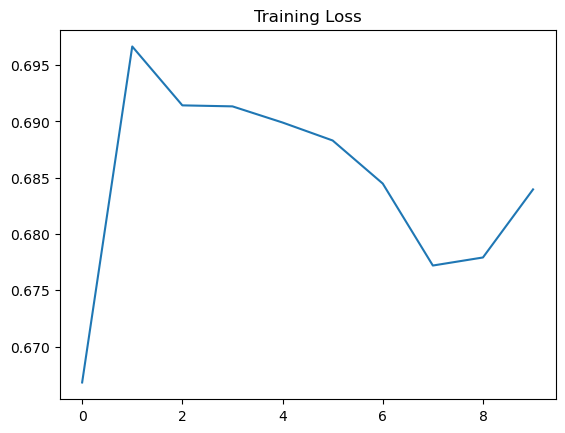

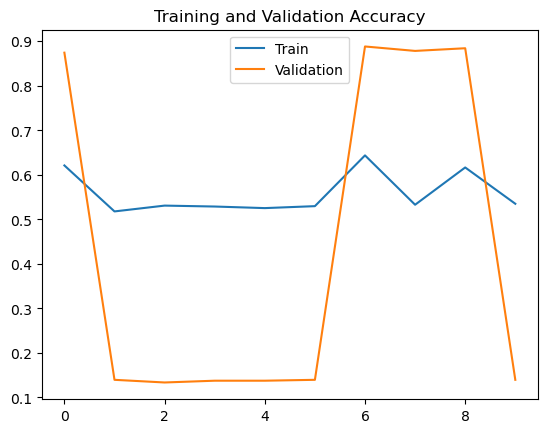

In [14]:
import matplotlib.pyplot as plt

# plot the training loss 
plt.plot(losses.cpu().numpy())
plt.title("Training Loss")
plt.show()

# plot the training and validation accuracy
plt.plot(accuracies[0].cpu().numpy(), label="Train")
plt.plot(accuracies[1].cpu().numpy(), label="Validation")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

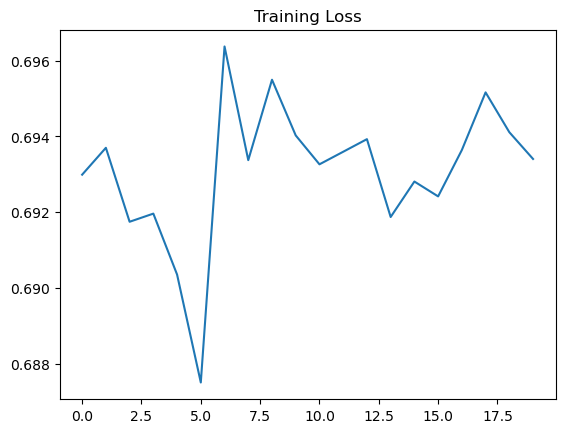

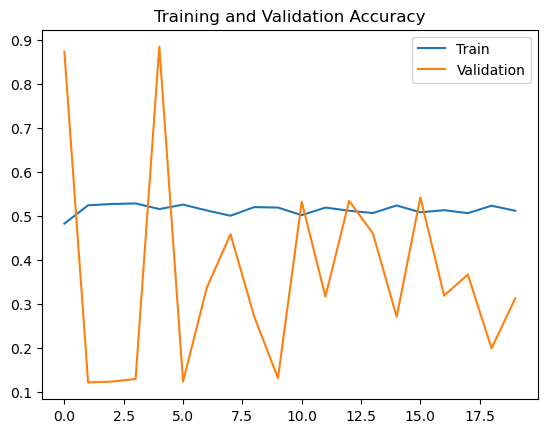

In [ ]:
model = RNN(input_size=len(characters) + 1, hidden_size=50, num_classes=2).to(device)
losses, accuracies = train(model, device, train_loader, val_loader, num_epochs=20, learning_rate=1e-3)

# plot the training loss 
plt.plot(losses.cpu().numpy())
plt.title("Training Loss")
plt.show()

# plot the training and validation accuracy
plt.plot(accuracies[0].cpu().numpy(), label="Train")
plt.plot(accuracies[1].cpu().numpy(), label="Validation")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# first test with more epochs 

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

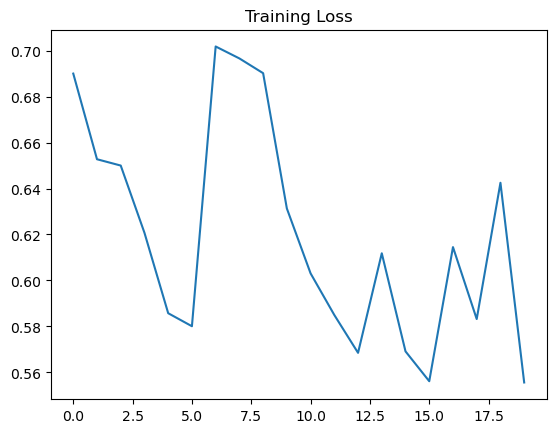

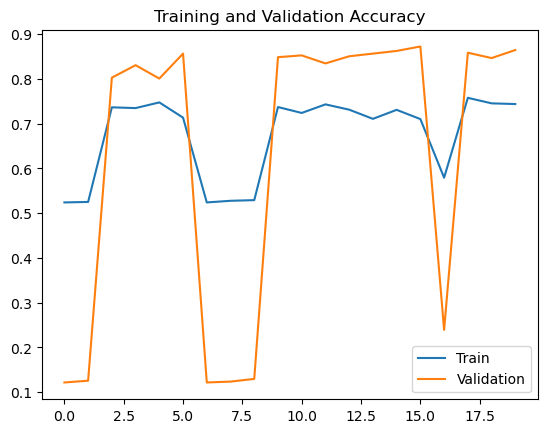

In [ ]:
model = RNN(input_size=len(characters) + 1, hidden_size=50, num_classes=2).to(device)
losses, accuracies = train(model, device, train_loader, val_loader, num_epochs=20, learning_rate=1e-4)

# plot the training loss 
plt.plot(losses.cpu().numpy())
plt.title("Training Loss")
plt.show()

# plot the training and validation accuracy
plt.plot(accuracies[0].cpu().numpy(), label="Train")
plt.plot(accuracies[1].cpu().numpy(), label="Validation")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# training for mroe epoch doesn't seems to decrease the training loss
# since the loss is very unstable, lets try to decrease the learning rate

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

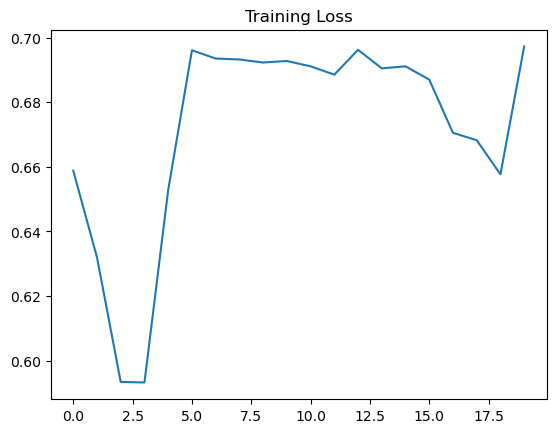

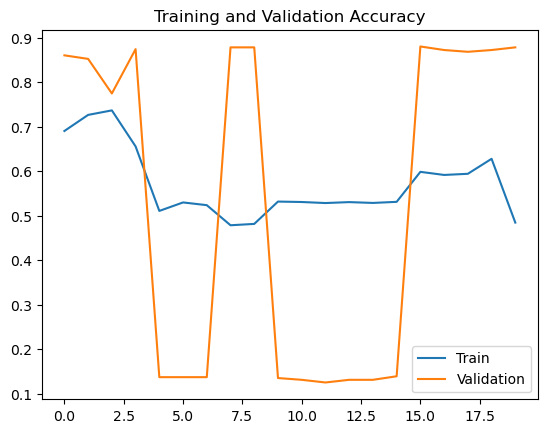

In [ ]:
model = RNN(input_size=len(characters) + 1, hidden_size=256, num_classes=2).to(device)
losses, accuracies = train(model, device, train_loader, val_loader, num_epochs=20, learning_rate=1e-4)

# plot the training loss 
plt.plot(losses.cpu().numpy())
plt.title("Training Loss")
plt.show()

# plot the training and validation accuracy
plt.plot(accuracies[0].cpu().numpy(), label="Train")
plt.plot(accuracies[1].cpu().numpy(), label="Validation")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# this time the training loss is still unstable, but decreasing....
# try increasing the size of the hidden unit to 256 so that it generalized better

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

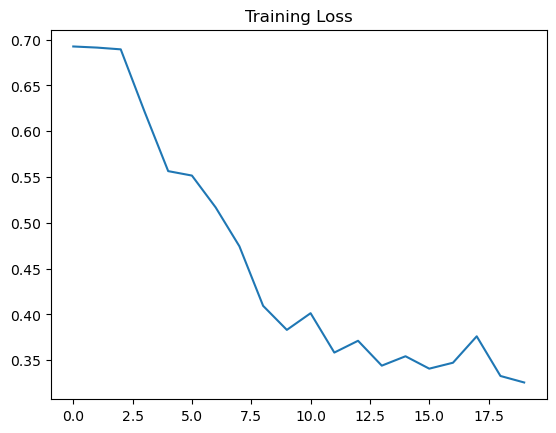

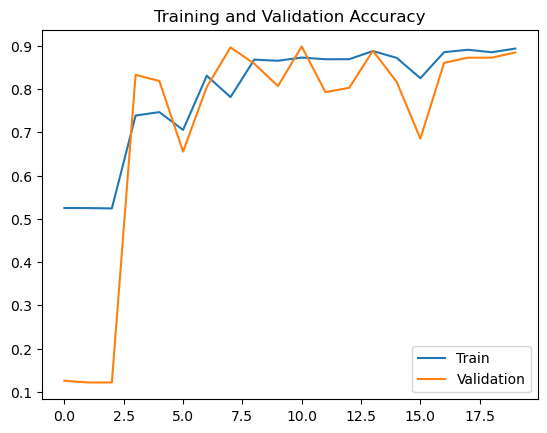

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size  # Store input_size
        # No embedding layer since we're using one-hot encoding
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # One-hot encode the input
        # x is the input sequence (sentence) as a tensor of integers (character indices)
        # x dimension is (batch_size, seq_len)
        x_one_hot = torch.nn.functional.one_hot(x, num_classes=self.input_size).float()
        # x one hot is 
        out, _ = self.rnn(x_one_hot)
        out = self.fc(out[:, -1, :])
        return out

model = RNN(input_size=len(characters) + 1, hidden_size=50, num_classes=2).to(device)
losses, accuracies = train(model, device, train_loader, val_loader, num_epochs=20, learning_rate=1e-4)

# plot the training loss 
plt.plot(losses.cpu().numpy())
plt.title("Training Loss")
plt.show()

# plot the training and validation accuracy
plt.plot(accuracies[0].cpu().numpy(), label="Train")
plt.plot(accuracies[1].cpu().numpy(), label="Validation")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# the training loss is worse than the previous model
# in the final iteration thats try the GRU with 256 hidden units

In [ ]:
# this result is significantly better, with much stable losses and higher accuracy

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [20]:
# display the false positive and false negative

def get_false_positive_and_negative(model, data, device):
    false_positive = []
    false_negative = []
    for sentences, labels in data:
        sentences, labels = sentences.to(device), labels.to(device)
        outputs = model(sentences)
        _, predicted = torch.max(outputs, 1)
        false_positive.append(((predicted == 1) & (labels == 0)).nonzero())
        false_negative.append(((predicted == 0) & (labels == 1)).nonzero())
    return false_positive, false_negative

false_positive, false_negative = get_false_positive_and_negative(model, test_loader, device)

# display the false positive rate
print("False Positive Rate: ", len(false_positive) / len(test_y))

# display the false negative rate
print("False Negative Rate: ", len(false_negative) / len(test_y))



False Positive Rate:  0.03225806451612903
False Negative Rate:  0.03225806451612903


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
# false positive will making ham message as spam, potentially causing the user to miss important messages

# false negative will making spam message as ham, potentially causing the user to be scammed

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [21]:
get_accuracy(model, test_loader, device)

0.8924731182795699

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [23]:
false_positive, false_negative = get_false_positive_and_negative(model, test_loader, device)

# display the false positive rate
print("False Positive Rate: ", len(false_positive) / len(test_y))

# display the false negative rate
print("False Negative Rate: ", len(false_negative) / len(test_y))


False Positive Rate:  0.03225806451612903
False Negative Rate:  0.03225806451612903


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `stoi` to look up the index
of each character in the vocabulary.

In [24]:
msg = "machine learning is sooo cool!"

msg_transformed = torch.tensor(turn_sentence_into_stoi(msg)).unsqueeze(0).to(device)
model.eval()
output = model(msg_transformed)
_, predicted = torch.max(output, 1)
if predicted == 1:
    print("This is a spam message")
else:
    print("This is a ham message")

    

This is a ham message


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
# the simple baseline model I want to be will be similar to how human detecting the spam message
# which is to associate words with spam

# I will run the TF-IDF on the spam emails, which vectorized the words in the spam emails
# after that I can try a simple logistic regression model to classify the spam and ham messages
